In [40]:
#In this notebook we will run the experiments with the pytorch-forecasting library

import os
import warnings

warnings.filterwarnings("ignore")

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

import pytorch_forecasting
from pytorch_forecasting import Baseline, RecurrentNetwork, TimeSeriesDataSet
from pytorch_forecasting.data.encoders import TorchNormalizer, EncoderNormalizer
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss, NormalDistributionLoss, RMSE




In [41]:
data = generate_ar_data(seasonality=20.0, timesteps=5000, n_series=1, seed=42)
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")

In [42]:
data = data.astype(dict(series=str))

# create dataset and dataloaders
max_encoder_length = 100
max_prediction_length = 50

validation_cutoff = data["time_idx"].max() - 1000
training_cutoff = validation_cutoff - max_prediction_length


context_length = max_encoder_length
prediction_length = max_prediction_length

data.head()

,series,time_idx,value,date
0,0,0,0.000000,2020-01-01
1,0,1,0.024652,2020-01-02
2,0,2,0.058442,2020-01-03
3,0,3,0.081475,2020-01-04
4,0,4,0.096084,2020-01-05


Epoch 0: 100%|██████████| 29/29 [09:35<00:00,  0.05it/s, v_num=18, train_loss_step=0.232, train_loss_epoch=0.387]

Finding best initial lr:  12%|█▏        | 12/100 [05:11<38:04, 25.96s/it]

<Axes: xlabel='date'>

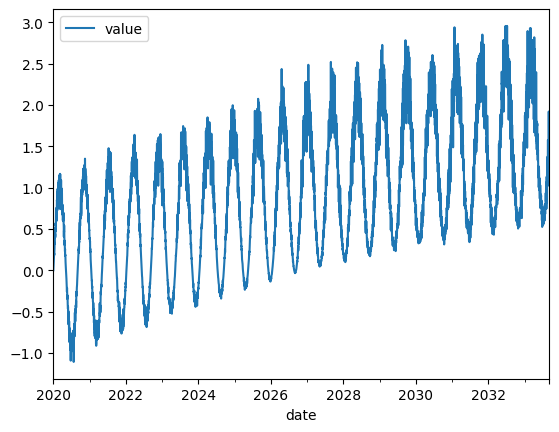

In [43]:
#plot the data value over time
data.plot(x="date", y="value")


In [44]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    group_ids=["series"],
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    target_normalizer=EncoderNormalizer(),
)

validation = TimeSeriesDataSet.from_dataset(training, data[lambda x: x.time_idx <= validation_cutoff], min_prediction_idx=training_cutoff + 1)
test = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=validation_cutoff + 1)

batch_size = 128
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, shuffle=False
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, shuffle=False
)

test_dataloader = test.to_dataloader(
    train=False, batch_size=1, num_workers=0, shuffle=False
)

In [45]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.3774)

In [46]:
for i in val_dataloader:
    print(i)
    

({'encoder_cat': tensor([], size=(1, 100, 0), dtype=torch.int64), 'encoder_cont': tensor([[[ 1.8832e+00],
         [ 1.9277e+00],
         [ 1.4090e+00],
         [ 2.1290e+00],
         [ 1.5896e+00],
         [ 1.7464e+00],
         [ 1.6095e+00],
         [ 1.4449e+00],
         [ 1.6844e+00],
         [ 1.5655e+00],
         [ 1.4663e+00],
         [ 1.2989e+00],
         [ 1.6125e+00],
         [ 2.0118e+00],
         [ 1.4559e+00],
         [ 1.6869e+00],
         [ 8.6739e-01],
         [ 1.3159e+00],
         [ 8.7547e-01],
         [ 7.1571e-01],
         [ 8.9675e-01],
         [ 1.4250e+00],
         [ 1.2994e+00],
         [ 1.0424e+00],
         [ 4.9074e-01],
         [ 8.1959e-01],
         [ 9.0689e-01],
         [ 8.2237e-01],
         [ 2.4213e-01],
         [ 4.4770e-01],
         [ 6.1187e-01],
         [ 7.1213e-01],
         [-3.0392e-03],
         [ 4.4352e-01],
         [ 4.6731e-01],
         [ 5.8018e-01],
         [ 4.9346e-01],
         [ 4.1878e-01],
      

In [47]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=1e-1)
net = RecurrentNetwork.from_dataset(
    training,
    cell_type="LSTM",
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=MAE(),
    optimizer="Adam",
)

Seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


`Trainer.fit` stopped: `max_steps=100` reached.
Finding best initial lr: 100%|██████████| 100/100 [01:20<00:00,  1.24it/s]
Learning rate set to 0.056234132519034905
Restoring states from the checkpoint path at c:\Users\euret\OneDrive\Documenti\PhD\Experiments\Adaptive_Norm\.lr_find_646fba1c-a795-4459-8dc7-a3c34b9acb18.ckpt
Restored all states from the checkpoint at c:\Users\euret\OneDrive\Documenti\PhD\Experiments\Adaptive_Norm\.lr_find_646fba1c-a795-4459-8dc7-a3c34b9acb18.ckpt


suggested learning rate: 0.056234132519034905


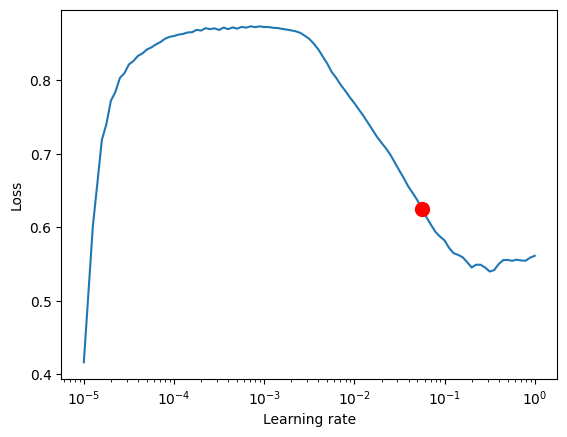

In [48]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [49]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", filename="best_model", mode="min", save_top_k=1)
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback, checkpoint_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = RecurrentNetwork.from_dataset(
    training,
    cell_type="LSTM",
    learning_rate=1e-2,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    optimizer="Adam",
    loss=MAE(), 
)

net.hparams.learning_rate = res.suggestion()

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAE            | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 0     
3 | rnn              | LSTM           | 11.4 K
4 | output_projector | Linear         | 31    
----------------------------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


Epoch 10:   3%|▎         | 1/29 [00:00<00:23,  1.21it/s, v_num=29, train_loss_step=0.0671, val_loss=0.236, train_loss_epoch=0.104]

In [50]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = RecurrentNetwork.load_from_checkpoint(best_model_path)

In [51]:
trainer.checkpoint_callback.best_model_path

'c:\\Users\\euret\\OneDrive\\Documenti\\PhD\\Experiments\\Adaptive_Norm\\lightning_logs\\version_29\\checkpoints\\best_model.ckpt'

In [52]:
#   best_model = net
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
print(MAE()(predictions.output, predictions.y))

net = best_model

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.1490)


In [53]:
raw_predictions = net.predict(
    val_dataloader, mode="raw", return_x=True, return_index=True, trainer_kwargs=dict(accelerator="cpu")
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


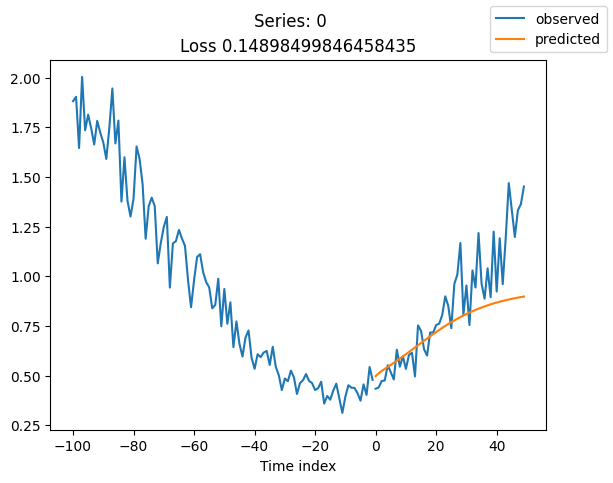

In [54]:
series = validation.x_to_index(raw_predictions.x)["series"]
for idx in range(1):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Series: {series.iloc[idx]}")

In [56]:
#Test the model on the test set

predictions = best_model.predict(test_dataloader, trainer_kwargs=dict(accelerator="cpu"), mode='raw', return_index=True, return_y=True, return_x=True)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 0: 100%|██████████| 29/29 [15:40<00:00,  0.03it/s, v_num=22, train_loss_step=0.336, train_loss_epoch=0.427]


In [57]:
print(MAE()(predictions.output.prediction.squeeze(), predictions.x['decoder_target']))

tensor(0.6469)


0
105
211
316
422
527
633
738
844
950


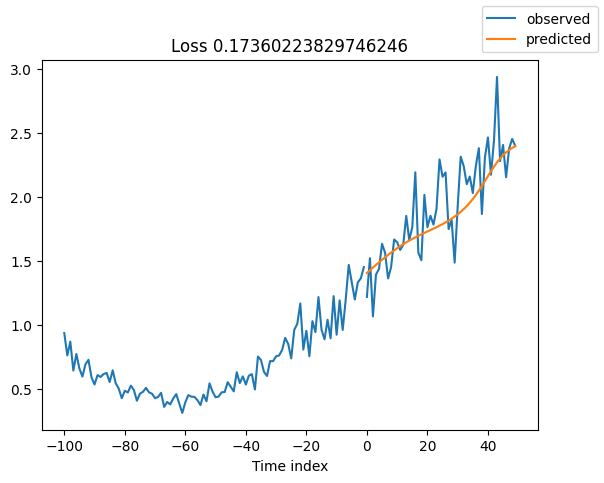

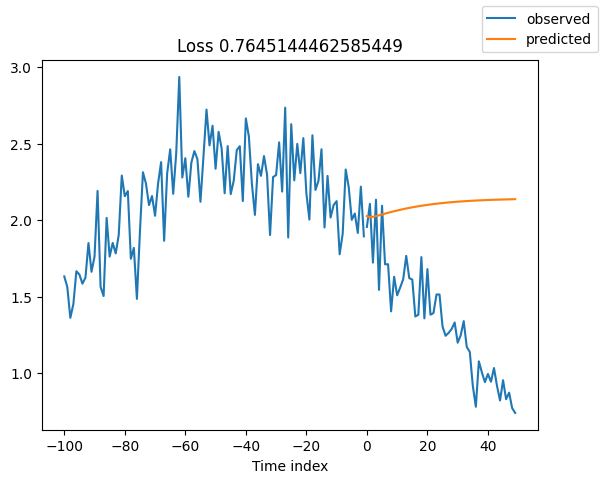

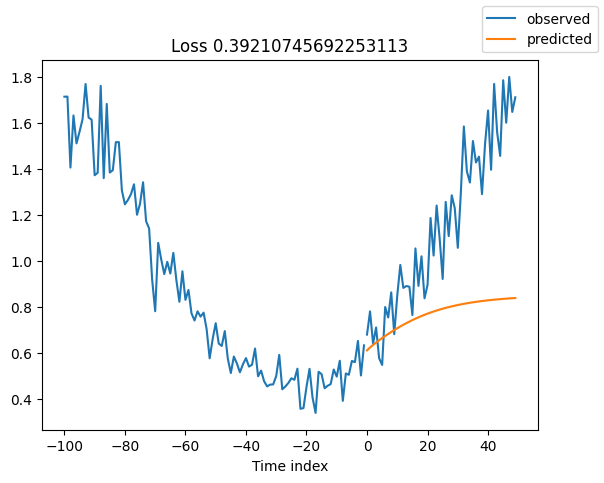

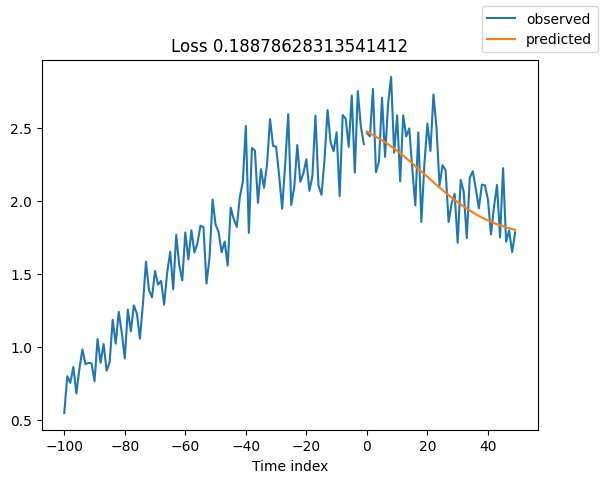

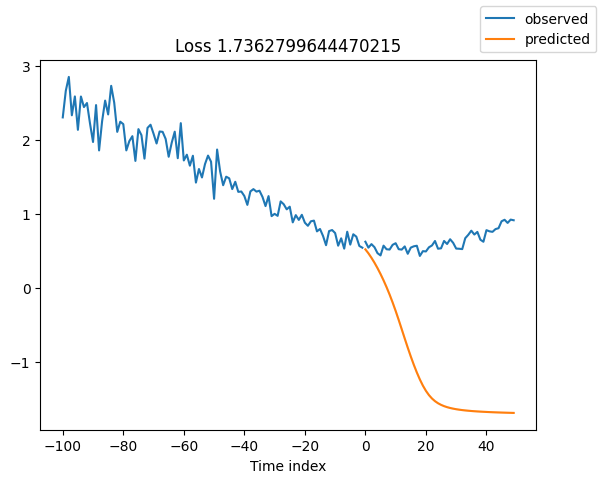

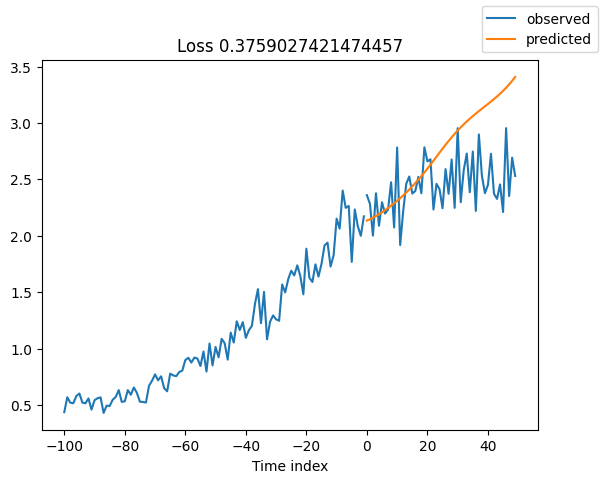

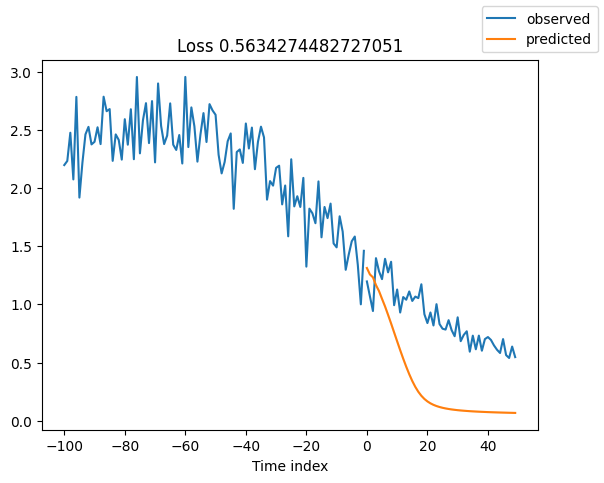

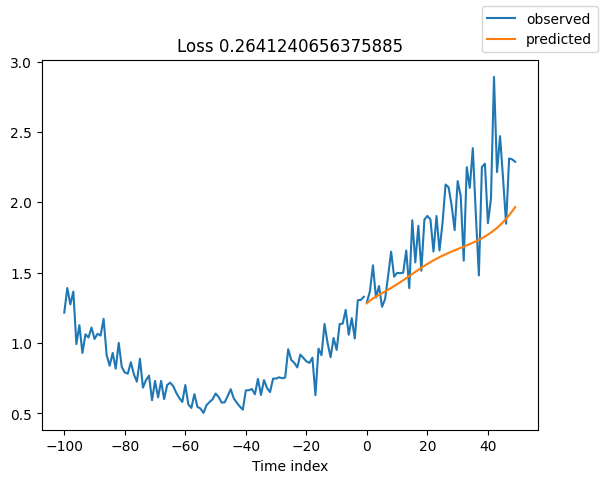

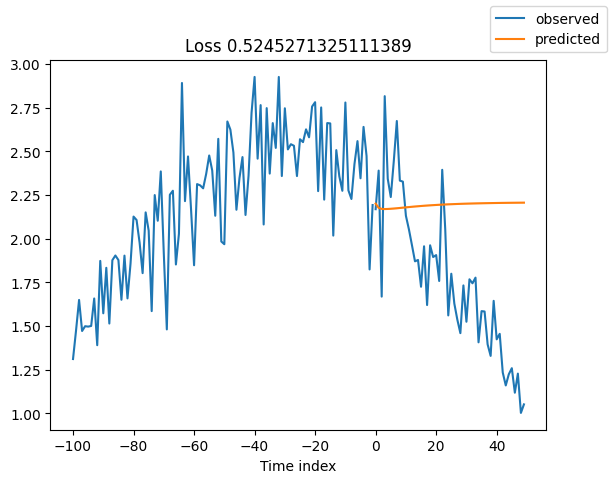

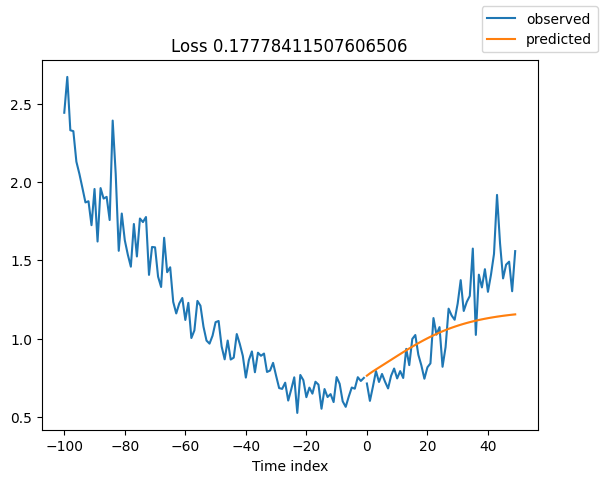

In [59]:
import numpy as np
for i in np.linspace(0, predictions.x['encoder_target'].shape[0]-1, 10, dtype=int):
    best_model.plot_prediction(predictions.x, predictions.output, idx=i, add_loss_to_title=True)